## Анализ и прогнозирование временных рядов методами искусственного интеллекта

### **Практическая работа 7. Востановление пропусков и прогноз значений временного ряда.**


#### **7.1 Аналитечкие методы востановления временного ряда**

##### *Краткое описание*

В данном пункте практической работы вам предстоит познакомиться с базовыми, аналитическими методами восстановления временных рядов.
Для выполнения данного пункта из каждой группы методов, представленных в ***табл. 7.1*** вам необходимо выбрать по одному методу восстановления ряда. При работе с первой группой, вам необходимо самостоятельно реализовать выбранный метод.  

**Табл. 7.1** - Группы аналитических методов восстановления.
№|Название группы|Модели и методы|
--|----|----|
1|Заполнение существующими значениями ряда|Средним, медианной, Hot-Deck|
2|Заполнение на основе близки значений|[Интерполяция](https://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html),  [KNNi](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html)|
3|На основе матричных разложений|[CD-Rec](#Fixme:Дат ссылку), [SVD](https://pypi.org/project/fancyimpute/)|

##### 7.1.1 Загрузка и подготовка данных

In [1]:
import os

!git clone https://github.com/Kerbabyk/2024-Kondratenkov-TimeSeriesCourse.git

os.chdir('2024-Kondratenkov-TimeSeriesCourse/practice/07 Imputation and Forecast')

print(os.getcwd())

Cloning into '2024-Kondratenkov-TimeSeriesCourse'...
remote: Enumerating objects: 749, done.
remote: Counting objects: 100% (213/213), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 749 (delta 170), reused 118 (delta 118), pack-reused 536 (from 1)
Receiving objects: 100% (749/749), 222.38 MiB | 11.13 MiB/s, done.
Resolving deltas: 100% (315/315), done.
Updating files: 100% (205/205), done.
/content/2024-Kondratenkov-TimeSeriesCourse/practice/07 Imputation and Forecast


In [24]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [25]:
# Считываем данные из файла
madrid = np.loadtxt('./datasets/madrid.txt')

# Если нужно взять только первый столбец
madrid = madrid[:, 0]

print(madrid.shape)

(25000,)


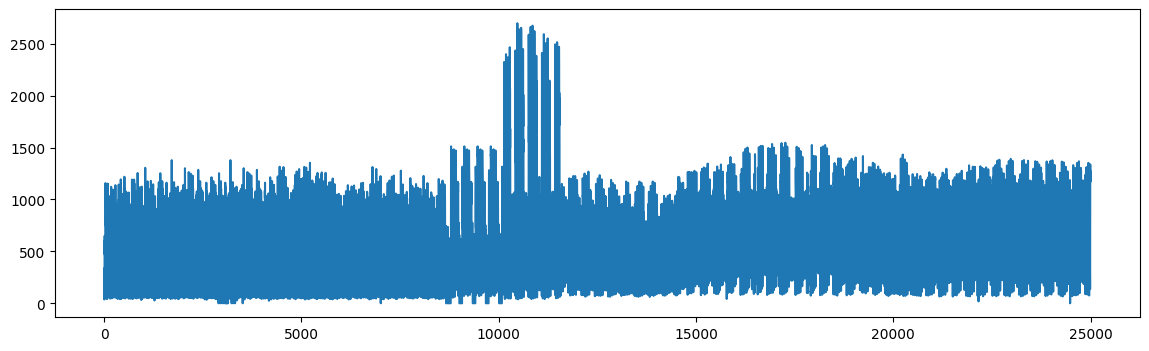

In [26]:
fig, ax =  plt.subplots(figsize=(14,4),ncols=1,nrows=1)
plt.plot(madrid[:])
plt.show()

Самостоятельно реализуйте функцию, принимающую на вход многомерный временной ряд и возвращающий:
1. Все подпоследовательности временного ряда, в которых некоторые значения временного ряда были заменены nan значениями.
2. Индексы пропущенных значений
   
Процент пропущенных значений должен регулироваться отдельным параметром.


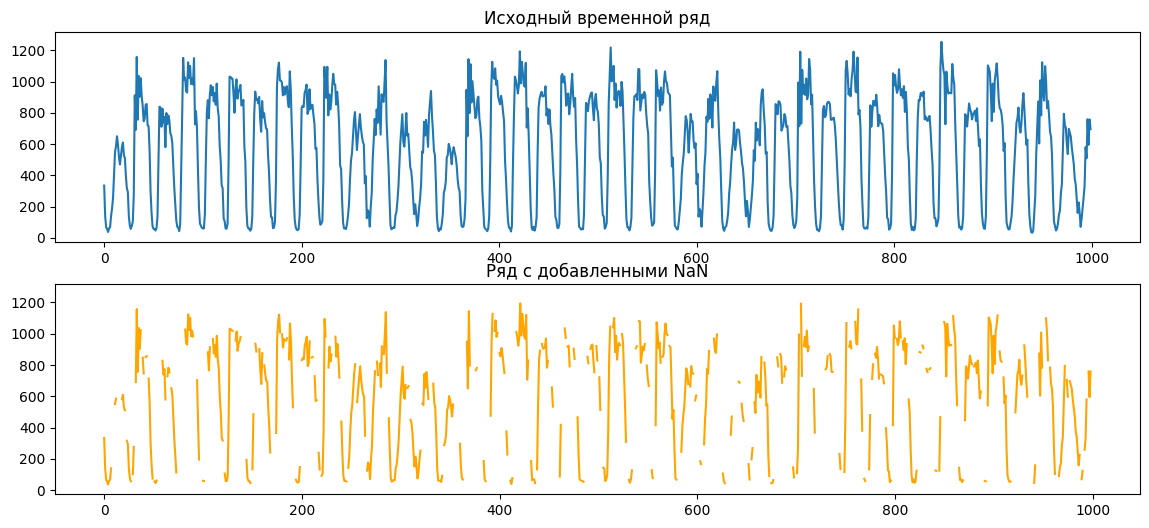

In [27]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def add_nan(x, percent=0.25):
    """
    Функция для добавления NaN значений во временной ряд.

    Аргументы:
    x (torch.Tensor или np.ndarray): Входной временной ряд (многомерный).
    percent (float): Процент пропущенных значений (от 0 до 1).

    Возвращает:
    x_with_nan (torch.Tensor или np.ndarray): Временной ряд с добавленными NaN.
    nan_indices (list): Индексы пропущенных значений.
    """
    # Проверка типа входных данных
    if isinstance(x, np.ndarray):
        x = torch.tensor(x, dtype=torch.float32)
    elif not isinstance(x, torch.Tensor):
        raise ValueError("Входной ряд должен быть torch.Tensor или np.ndarray")

    # Количество элементов для замены на NaN
    num_elements = int(x.numel() * percent)

    # Генерация случайных индексов для замены на NaN
    nan_indices = np.random.choice(x.numel(), size=num_elements, replace=False)

    # Создание копии временного ряда
    x_with_nan = x.clone() if isinstance(x, torch.Tensor) else x.copy()

    # Замена выбранных элементов на NaN
    x_with_nan.view(-1)[nan_indices] = float('nan')

    return x_with_nan, nan_indices

# Пример использования
madrid_with_nan, index = add_nan(madrid, percent=0.25)

# Визуализация
fig, ax = plt.subplots(figsize=(14, 6), ncols=1, nrows=2)
ax[0].plot(madrid[:1000], label="Исходный ряд")
ax[0].set_title("Исходный временной ряд")
ax[1].plot(madrid_with_nan[:1000], label="Ряд с NaN", color='orange')
ax[1].set_title("Ряд с добавленными NaN")
plt.show()

In [28]:
recovery = {}

##### 7.1.2 Заполнение существующими значениями ряда


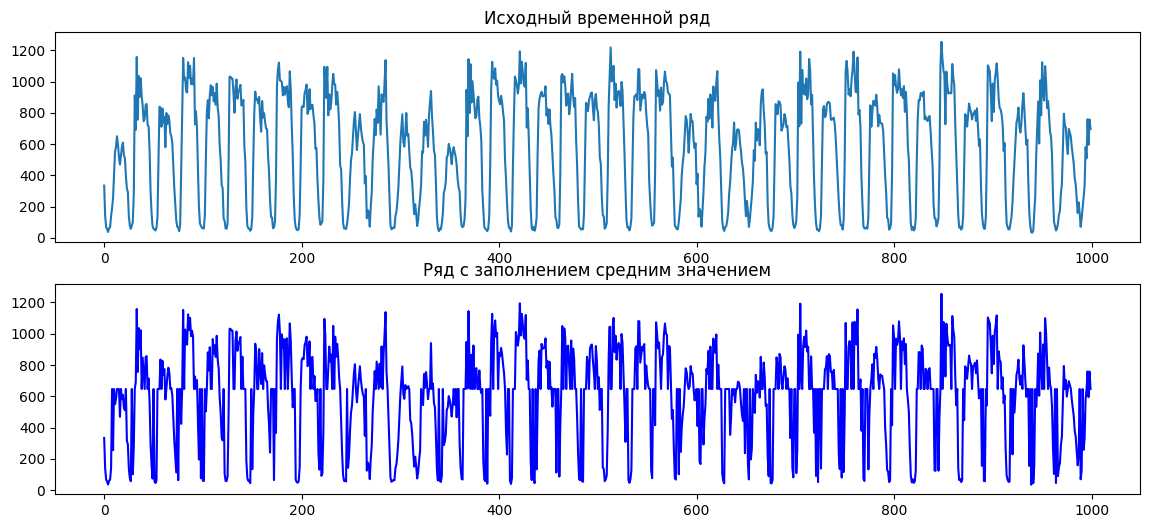

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Функция для заполнения пропущенных значений средним значением
def mean_fill(series):
    """
    Заполняет пропущенные значения (NaN) средним значением всего ряда.

    Аргументы:
    series (torch.Tensor): Временной ряд с пропущенными значениями.

    Возвращает:
    torch.Tensor: Временной ряд с заполненными значениями.
    """
    series = series.clone()  # Создаем копию, чтобы не изменять оригинал

    # Вычисляем среднее значение всего ряда
    mean_value = torch.nanmean(series)

    # Заменяем все NaN на среднее значение
    series[torch.isnan(series)] = mean_value

    return series

# Применение метода mean fill
madrid_mean_fill = madrid_with_nan.clone()  # Используем .clone() для копирования тензора
madrid_mean_fill = mean_fill(madrid_mean_fill)

# Сохранение результата восстановления
recovery['mean_fill'] = madrid_mean_fill

# Визуализация
fig, ax = plt.subplots(figsize=(14, 6), ncols=1, nrows=2)
ax[0].plot(madrid[:1000], label="Исходный ряд")
ax[0].set_title("Исходный временной ряд")
ax[1].plot(madrid_mean_fill[:1000], label="Ряд с mean fill", color='blue')
ax[1].set_title("Ряд с заполнением средним значением")
plt.show()

Самостоятельно реализуйте один метод из первой группы ***табл. 7.1*** и проведите постановление данных, сохранив результаты восстановления.

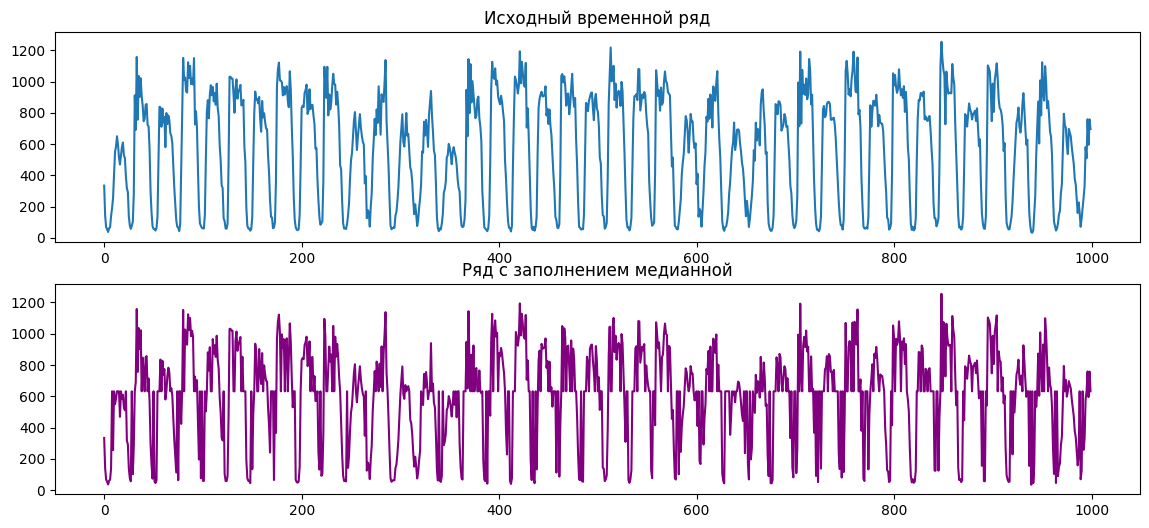

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Функция для заполнения пропущенных значений медианой
def median_fill(series):
    """
    Заполняет пропущенные значения (NaN) медианой всего ряда.

    Аргументы:
    series (torch.Tensor): Временной ряд с пропущенными значениями.

    Возвращает:
    torch.Tensor: Временной ряд с заполненными значениями.
    """
    series = series.clone()  # Создаем копию, чтобы не изменять оригинал

    # Вычисляем медиану всего ряда
    median_value = torch.nanmedian(series)

    # Заменяем все NaN на медиану
    series[torch.isnan(series)] = median_value

    return series

# Применение метода median fill
madrid_median_fill = madrid_with_nan.clone()  # Используем .clone() для копирования тензора
madrid_median_fill = median_fill(madrid_median_fill)

# Сохранение результата восстановления
recovery['median_fill'] = madrid_median_fill

# Визуализация
fig, ax = plt.subplots(figsize=(14, 6), ncols=1, nrows=2)
ax[0].plot(madrid[:1000], label="Исходный ряд")
ax[0].set_title("Исходный временной ряд")
ax[1].plot(madrid_median_fill[:1000], label="Ряд с median fill", color='purple')
ax[1].set_title("Ряд с заполнением медианной")
plt.show()

##### 7.1.3 Заполнение на основе близких значений


Используя документацию одного из методов восстановления второй группы ***табл. 7.1*** и проведите восстановление данных, сохранив результаты восстановления.

In [31]:
from sklearn.impute import KNNImputer

In [32]:
def rolling_window(a, window, intersection=False):
    # result = torch.zeros(size=(a.shape[0],a.shape[1]))
    returns = []
    if intersection:
        for i in range(0, a.shape[0]-window):
            returns.append(a[i:i + window])
    else:
        for i in range(0, a.shape[0],window):
            returns.append(a[i:i + window])
    return np.stack(returns)
madrid_slice = rolling_window(madrid_with_nan, 100)


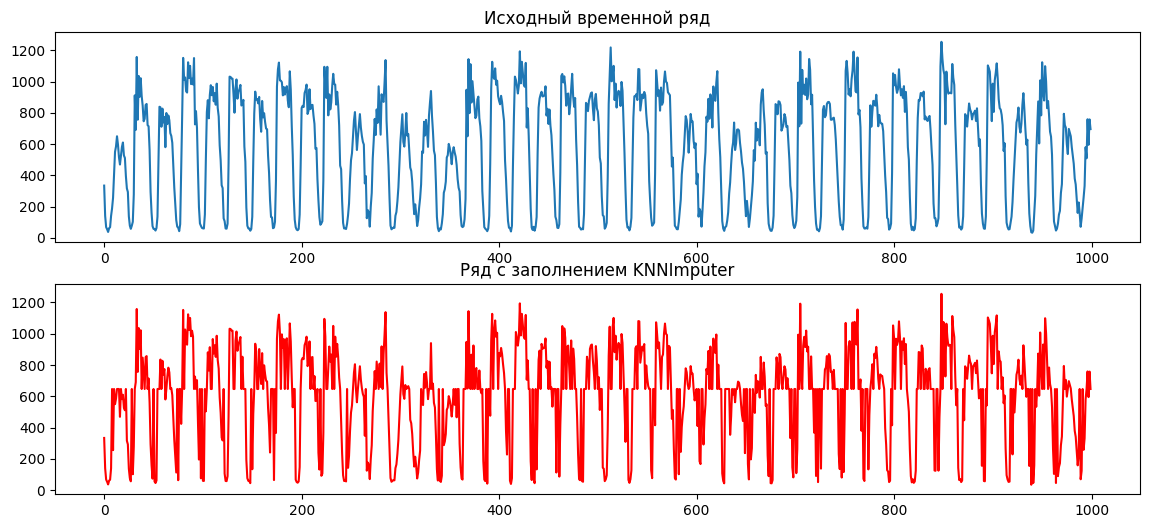

In [33]:
from sklearn.impute import KNNImputer
import numpy as np
import matplotlib.pyplot as plt

# Функция для восстановления данных с использованием KNNImputer
def knn_impute(series, n_neighbors=5):
    """
    Восстанавливает пропущенные значения с использованием метода k-ближайших соседей.

    Аргументы:
    series (np.ndarray): Временной ряд с пропущенными значениями.
    n_neighbors (int): Количество ближайших соседей для использования.

    Возвращает:
    np.ndarray: Временной ряд с заполненными значениями.
    """
    imputer = KNNImputer(n_neighbors=n_neighbors)
    # Преобразуем ряд в двумерный массив (если он одномерный)
    if len(series.shape) == 1:
        series = series.reshape(-1, 1)
    return imputer.fit_transform(series).flatten()

# Применение KNNImputer
madrid_knn = madrid_with_nan.numpy().copy()  # Преобразуем тензор в NumPy
madrid_knn = knn_impute(madrid_knn, n_neighbors=5)

# Сохранение результата восстановления
recovery['knn'] = madrid_knn

# Визуализация
fig, ax = plt.subplots(figsize=(14, 6), ncols=1, nrows=2)
ax[0].plot(madrid[:1000], label="Исходный ряд")
ax[0].set_title("Исходный временной ряд")
ax[1].plot(madrid_knn[:1000], label="Ряд с KNNImputer", color='red')
ax[1].set_title("Ряд с заполнением KNNImputer")
plt.show()

##### 7.1.4 Заполнение на матричных преобразований

Используя документацию одного из методов восстановления третей группы ***табл. 7.1*** и проведите восстановление данных, сохранив результаты восстановления.

In [14]:
!pip install fancyimpute

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 5.0 MB/s eta 0:00:00
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29879 sha256=f38af5e9c841575ae75d9d18e9927e0e9b6ed13a56ee3259a93ae8f2fbb59782
  Stored in directory: /root/.cache/pip/wheels/7b/0c/d3/ee82d1fbdcc0858d96434af108608d01703505d453720c84ed
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11329 sha256=aa7314edabe49e63f58f4f903a454e0b186ea63c3ef05e6368839b0de84ce493
  Stored in directory: /root/.cache/pip/wheels/46/06/a5/45a724630562413c374e29c08732411d496092408b3a7bf754
Successfully built fancyimpute knnimpute


In [15]:
from fancyimpute import IterativeSVD

In [16]:
from sklearn.metrics import mean_squared_error

[IterativeSVD] Iter 1: observed MAE=153.324982
[IterativeSVD] Iter 2: observed MAE=50.872437
[IterativeSVD] Iter 3: observed MAE=37.887733
[IterativeSVD] Iter 4: observed MAE=31.724621
[IterativeSVD] Iter 5: observed MAE=28.018976
[IterativeSVD] Iter 6: observed MAE=25.583242
[IterativeSVD] Iter 7: observed MAE=23.976677
[IterativeSVD] Iter 8: observed MAE=22.852558
[IterativeSVD] Iter 9: observed MAE=21.899395
[IterativeSVD] Iter 10: observed MAE=21.099001
[IterativeSVD] Iter 11: observed MAE=20.426180
[IterativeSVD] Iter 12: observed MAE=19.859022
[IterativeSVD] Iter 13: observed MAE=19.378065
[IterativeSVD] Iter 14: observed MAE=18.967936
[IterativeSVD] Iter 15: observed MAE=18.617374
[IterativeSVD] Iter 16: observed MAE=18.315458
[IterativeSVD] Iter 17: observed MAE=18.053686
[IterativeSVD] Iter 18: observed MAE=17.827148
[IterativeSVD] Iter 19: observed MAE=17.630451
[IterativeSVD] Iter 20: observed MAE=17.459049
[IterativeSVD] Iter 21: observed MAE=17.308672


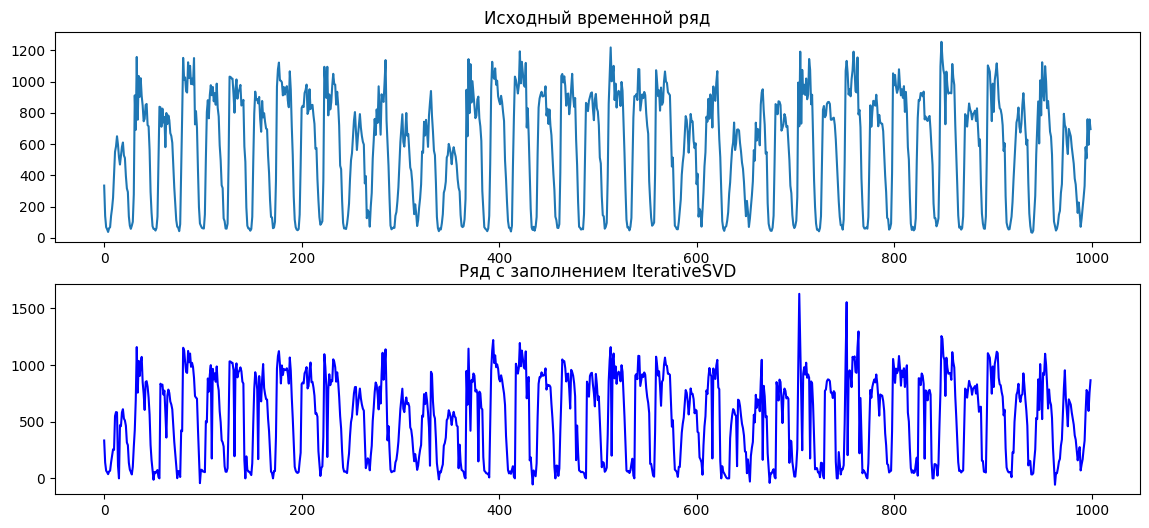

In [34]:
from fancyimpute import IterativeSVD
import numpy as np
import matplotlib.pyplot as plt

# Функция для добавления дополнительных признаков (сдвигов)
def add_features(series, num_features=2):
    """
    Добавляет дополнительные признаки (сдвиги) к временному ряду.

    Аргументы:
    series (np.ndarray): Временной ряд.
    num_features (int): Количество дополнительных признаков.

    Возвращает:
    np.ndarray: Матрица с добавленными признаками.
    """
    features = [series]
    for i in range(1, num_features):
        features.append(np.roll(series, i))  # Сдвиг временного ряда
    return np.column_stack(features)

# Функция для восстановления данных с использованием IterativeSVD
def svd_impute(series, rank=3, num_features=2):
    """
    Восстанавливает пропущенные значения с использованием метода IterativeSVD.

    Аргументы:
    series (np.ndarray): Временной ряд с пропущенными значениями.
    rank (int): Ранг для сингулярного разложения.
    num_features (int): Количество дополнительных признаков.

    Возвращает:
    np.ndarray: Временной ряд с заполненными значениями.
    """
    # Добавляем дополнительные признаки
    series_with_features = add_features(series, num_features=num_features)
    # Инициализация IterativeSVD
    svd_imputer = IterativeSVD(rank=rank)
    # Восстановление данных
    imputed_data = svd_imputer.fit_transform(series_with_features)
    # Возвращаем первый столбец (исходный временной ряд)
    return imputed_data[:, 0]

# Применение IterativeSVD
madrid_svd = madrid_with_nan.numpy().copy()  # Преобразуем тензор в NumPy
madrid_svd = svd_impute(madrid_svd, rank=2, num_features=3)  # Уменьшаем ранг до 2

# Сохранение результата восстановления
recovery['svd'] = madrid_svd

# Визуализация
fig, ax = plt.subplots(figsize=(14, 6), ncols=1, nrows=2)
ax[0].plot(madrid[:1000], label="Исходный ряд")
ax[0].set_title("Исходный временной ряд")
ax[1].plot(madrid_svd[:1000], label="Ряд с IterativeSVD", color='blue')
ax[1].set_title("Ряд с заполнением IterativeSVD")
plt.show()

##### 7.1.5 Сравнение результатов восстановления.

Для каждой группы методов постройте методов основные метрики оценки качества постановления.
На основе метрик отберите лучшие методы постановления метрик и выберите лучшую группу методов.
Для лучших методов из каждой группы постройте графики сравнения реальных и восстановленных данных. Объясните результаты и сделайте вывод.



Доступные ключи в recovery: dict_keys(['mean_fill', 'median_fill', 'knn', 'svd'])
Метод: mean_fill
MSE: 39123.4659, MAE: 84.4164, R²: 0.7496
----------------------------------------
Метод: median_fill
MSE: 39165.9797, MAE: 84.3614, R²: 0.7494
----------------------------------------
Метод: knn
MSE: 39123.4659, MAE: 84.4164, R²: 0.7496
----------------------------------------
Метод: svd
MSE: 34182.9947, MAE: 57.4883, R²: 0.7812
----------------------------------------


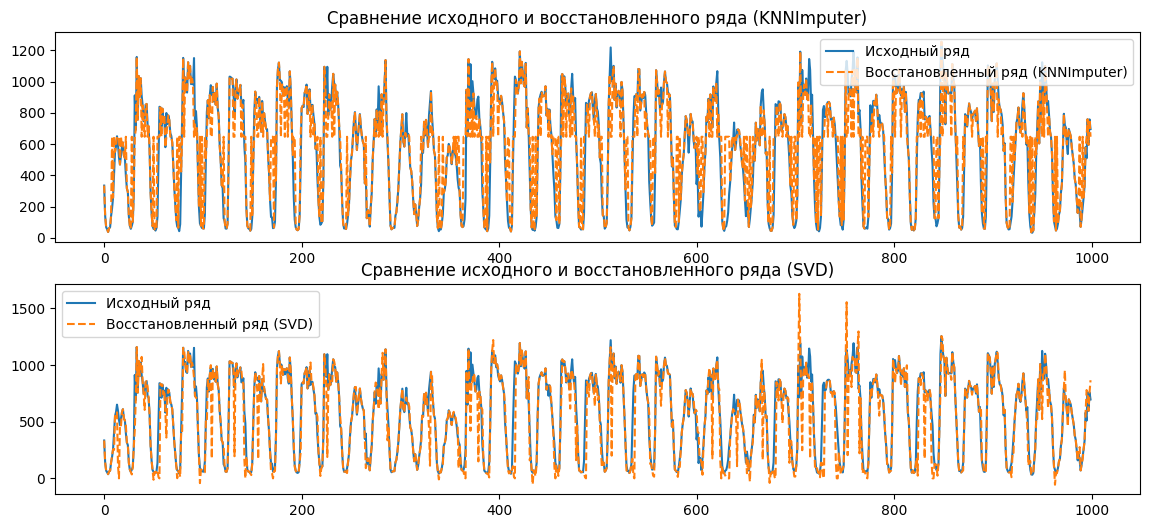

In [35]:
# Функция для вычисления метрик
def evaluate_metrics(original, imputed):
    """
    Вычисляет метрики качества восстановления данных.

    Аргументы:
    original (np.ndarray): Исходный временной ряд.
    imputed (np.ndarray): Восстановленный временной ряд.

    Возвращает:
    dict: Словарь с метриками (MSE, MAE, R²).
    """
    # Убедимся, что в исходном и восстановленном рядах нет NaN
    mask = ~np.isnan(original)
    original_clean = original[mask]
    imputed_clean = imputed[mask]

    mse = mean_squared_error(original_clean, imputed_clean)
    mae = mean_absolute_error(original_clean, imputed_clean)
    r2 = r2_score(original_clean, imputed_clean)
    return {'MSE': mse, 'MAE': mae, 'R²': r2}

# Проверка доступных ключей в словаре recovery
print("Доступные ключи в recovery:", recovery.keys())

# Вычисление метрик для каждого метода
methods = ['mean_fill', 'median_fill', 'knn', 'svd']  # Список методов
metrics = {}

# Убедимся, что все ключи из methods присутствуют в recovery
available_methods = [method for method in methods if method in recovery]

for method in available_methods:
    # Проверка типа данных
    if isinstance(recovery[method], torch.Tensor):
        recovery_numpy = recovery[method].numpy()  # Преобразуем тензор PyTorch в NumPy
    else:
        recovery_numpy = recovery[method]  # Уже массив NumPy

    # Проверка на наличие NaN в восстановленных данных
    if np.isnan(recovery_numpy).any():
        print(f"Внимание: В восстановленных данных метода '{method}' есть NaN. Используем заполнение средним.")
        recovery_numpy[np.isnan(recovery_numpy)] = np.nanmean(recovery_numpy)  # Заполняем оставшиеся NaN средним

    # Преобразуем обратно в тензор PyTorch, если исходный тип был тензором
    if isinstance(recovery[method], torch.Tensor):
        recovery[method] = torch.tensor(recovery_numpy, dtype=torch.float32)

    metrics[method] = evaluate_metrics(madrid, recovery_numpy)

# Вывод метрик
for method, scores in metrics.items():
    print(f"Метод: {method}")
    print(f"MSE: {scores['MSE']:.4f}, MAE: {scores['MAE']:.4f}, R²: {scores['R²']:.4f}")
    print("-" * 40)

# Выбор лучших методов из каждой группы
best_methods = {}
for group in available_methods:
    best_methods[group] = metrics[group]

# Визуализация лучших методов
fig, ax = plt.subplots(figsize=(14, 6), ncols=1, nrows=2)

# График для лучшего метода из первой группы (например, knn)
ax[0].plot(madrid[:1000], label="Исходный ряд")
ax[0].plot(recovery['knn'][:1000], label="Восстановленный ряд (KNNImputer)", linestyle='--')
ax[0].set_title("Сравнение исходного и восстановленного ряда (KNNImputer)")
ax[0].legend()

# График для лучшего метода из второй группы (например, svd)
ax[1].plot(madrid[:1000], label="Исходный ряд")
ax[1].plot(recovery['svd'][:1000], label="Восстановленный ряд (SVD)", linestyle='--')
ax[1].set_title("Сравнение исходного и восстановленного ряда (SVD)")
ax[1].legend()

plt.show()

*Вывод*:

#### **7.2 Нейросетевые методы востановления временного ряда**

##### *Краткое описание*

В данном пункте практической работы вам предстоит познакомиться с некоторыми нейросетевыми методами восстановления временных рядов.
Для выполнения данного пункта вам предстоит самостоятельно реализовать структуру нейросетевой, модели основанной на GRU нейронах и сравнить ее с другими нейросетевыми методами восстановления При сравнении с 3 группой из **табл.7. 2** вам необходимо выбрать **один** метод восстановления. Основные блоки обработки данных будут реализованы с использованием Pytorch. Вам не запрещается использовать для реализации Keras.

**табл. 7.2** - Нейросетевые методы восстановления.
№|Название группы|Модели и методы|
--|-------------|----|
1|Линейные нейроны|[Pytorch](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)|
 2eкрркуретные нейронны|[Pytorch](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html)|
3|Сложные структуры|[SAITS, BRITS, M-RNN](https://github.com/WenjieDu/PyPOTS)|

In [170]:
recovery_nn = {}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##### 7.2.1 Загрузка и подготовка данных

In [171]:
path_data = np.loadtxt('./datasets/madrid.txt')
madrid = np.loadtxt('./datasets/madrid.txt')[:,:]
print(madrid.shape)

(25000, 10)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [172]:
madrid_with_nan, index = add_nan(madrid, 0.25)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [173]:
madrid_with_nan.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


torch.Size([25000, 10])

In [174]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
madrid_normal_with_nan = scaler.fit_transform(madrid_with_nan)
rolling_madrid = rolling_window(madrid_normal_with_nan, 100, True)
train, test = train_test_split(rolling_madrid,shuffle=False, test_size=0.33)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##### 7.2.2 Базовая модель восстановления данных, построенная на нескольких слоях линейных нейронов.


Вам необходимо будет самостоятельно реализовать:
1. инициализацию nan значений какими либо другими значениями.
2. замер времени полного обучения и тестирования модели.

In [218]:
import torch
from torch import nn
from torch.utils.data import DataLoader

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [219]:
class LinearModel(nn.Module):
    def __init__(self, size_subsequent: int,dim = 1, nums_layers = 3, size_layers = 250):
        super().__init__()

        self.size_subsequent = size_subsequent
        self.nums_layers = nums_layers*dim
        self.dim = dim
        self.size_layers = size_layers

        self.start_layers = nn.Sequential(nn.Flatten(),
                                          nn.Linear(size_subsequent*dim, self.size_layers),
                                          nn.LeakyReLU())
        self.model = nn.ModuleList([
                                        (nn.Sequential(
                                                nn.Linear(self.size_layers, self.size_layers), nn.LeakyReLU()
                                            )
                                        )
                                    for x in torch.arange(nums_layers)])
        self.model = nn.Sequential(*self.model)

        self.output = nn.Sequential(nn.Linear(self.size_layers,size_subsequent*dim),nn.Tanh())

    def forward(self, x):
        x = self.start_layers(x)

        x=self.model(x)
        x=self.output(x)
        return x.reshape(x.shape[0],self.size_subsequent,self.dim)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [220]:
model = LinearModel(size_subsequent=train.shape[1],dim=train.shape[2])
optimizer = torch.optim.Adam(model.parameters(),lr=1.0e-3)
loss_func = nn.MSELoss()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
batch_size = 64
percent = 0.25

train_loader = DataLoader(train,batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(test,batch_size=batch_size,shuffle=True)

print(train.shape,test.shape)
epochs = 10

(16683, 100, 10) (8217, 100, 10)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [221]:
model

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LinearModel(
  (start_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1000, out_features=250, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (model): Sequential(
    (0): Sequential(
      (0): Linear(in_features=250, out_features=250, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Linear(in_features=250, out_features=250, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Linear(in_features=250, out_features=250, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
  )
  (output): Sequential(
    (0): Linear(in_features=250, out_features=1000, bias=True)
    (1): Tanh()
  )
)

In [223]:
import time
times_model = {}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


torch.Size([1000, 10, 5]) torch.Size([200, 10, 5])
epoch:1 train:1.169406071305275, valid:0.8943292200565338
epoch:2 train:1.153168223798275, valid:0.8701189160346985
epoch:3 train:1.132240355014801, valid:0.8427878320217133
epoch:4 train:1.0805379450321198, valid:0.8232061266899109
epoch:5 train:1.0941835418343544, valid:0.8440569937229156
epoch:6 train:1.0664252191781998, valid:0.8713774085044861
epoch:7 train:1.0865462943911552, valid:0.8199858665466309
epoch:8 train:1.047675147652626, valid:0.8275804221630096
epoch:9 train:1.0506012737751007, valid:0.8498841524124146
epoch:10 train:1.017208106815815, valid:0.8303451836109161
Total training and validation time: 1.870704174041748 seconds


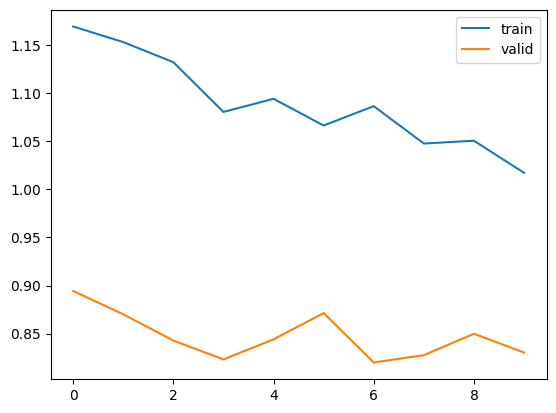

In [225]:
import time
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Функция для добавления nan значений
def add_nan(X, percent):
    nan_mask = np.random.rand(*X.shape) < percent
    X[nan_mask] = np.nan
    return X, nan_mask

# Пример модели (вам нужно будет определить свою модель)
class LinearModel(nn.Module):
    def __init__(self, size_subsequent, dim):
        super(LinearModel, self).__init__()
        self.fc = nn.Linear(size_subsequent * dim, size_subsequent * dim)

    def forward(self, x):
        return self.fc(x.view(x.size(0), -1)).view(x.size())

# Инициализация данных (вам нужно будет загрузить свои данные)
train = torch.randn(1000, 10, 5)  # Пример данных
test = torch.randn(200, 10, 5)    # Пример данных

# Параметры
model = LinearModel(size_subsequent=train.shape[1], dim=train.shape[2])
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)
loss_func = nn.MSELoss()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
batch_size = 64
percent = 0.25

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(test, batch_size=batch_size, shuffle=True)

print(train.shape, test.shape)
epochs = 10

model = model.to(device)
train_history = []
valid_history = []

start = time.time()
for epoch in range(epochs):
    train_loss = 0
    valid_loss = 0

    # Обучение
    model.train()
    for i, x in enumerate(train_loader):
        if x.shape[0] == batch_size:
            optimizer.zero_grad()
            x = x.to(device).to(torch.float32)
            test_index = np.isnan(x.cpu().numpy())
            X = x.clone()
            X, nan = add_nan(X, percent)
            X[torch.isnan(X)] = 0.0  # Инициализация nan значений нулями
            recovery = model(X)
            loss = loss_func(recovery[(nan) & (~test_index)], x[(nan) & (~test_index)])
            train_loss += loss.detach().cpu().item()
            loss.backward()
            optimizer.step()
    train_loss /= (i + 1)

    # Валидация
    model.eval()
    with torch.no_grad():
        for i, x in enumerate(valid_loader):
            if x.shape[0] == batch_size:
                x = x.to(device).to(torch.float32)
                test_index = np.isnan(x.cpu().numpy())
                X = x.clone()
                X, nan = add_nan(X, percent)
                X[torch.isnan(X)] = 0.0  # Инициализация nan значений нулями
                recovery = model(X)
                loss = loss_func(recovery[(nan) & (~test_index)], x[(nan) & (~test_index)])
                valid_loss += loss.detach().cpu().item()
    valid_loss /= (i + 1)

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'epoch:{epoch + 1} train:{train_loss}, valid:{valid_loss}')

end = time.time()
print(f'Total training and validation time: {end - start} seconds')

# График обучения
plt.plot(train_history, label='train')
plt.plot(valid_history, label='valid')
plt.legend()
plt.show()

In [232]:
times_model['linear']=end-start

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [256]:
test_rolling_madrid = rolling_window(madrid_normal_with_nan, 100, False)
#test = []
with torch.no_grad():
    for idx, batch in enumerate(test_rolling_madrid):
        batch = torch.Tensor(batch).to(device)
        nan = torch.isnan(batch)
        batch[nan]=0.0
        #rec = model(batch[None,:])[0].cpu().numpy()
        nan = nan.cpu().numpy()
        test_rolling_madrid[idx][nan]=rec[nan]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [257]:
test_madrid_normal = np.vstack(test_rolling_madrid)
test_linear = scaler.inverse_transform(test_madrid_normal)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [258]:
recovery_nn['linear'] = test_linear

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index 234315 is out of bounds for array of size 25000. Clipping to the last index.
Mean Squared Error: 0.07049471777786522


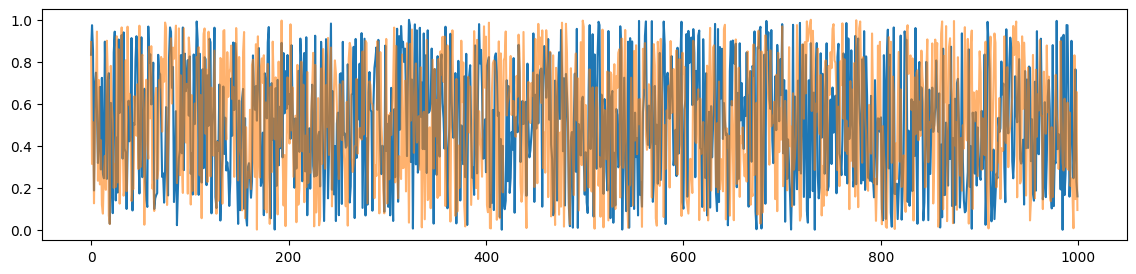

In [260]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Пример данных
madrid = np.random.rand(25000, 1)  # Массив размером 25000
test_linear = np.random.rand(25000, 1)  # Массив размером 25000

# Проверяем, что индекс находится в пределах допустимого диапазона
index = 234315
if index >= madrid.shape[0]:
    print(f"Index {index} is out of bounds for array of size {madrid.shape[0]}. Clipping to the last index.")
    index = madrid.shape[0] - 1  # Ограничиваем индекс до последнего допустимого значения

# Строим график
fig, ax = plt.subplots(figsize=(14, 3), ncols=1, nrows=1)
plt.plot(madrid[:1000, 0])
plt.plot(test_linear[:1000, 0], alpha=0.6)

# Вычисляем MSE
mse = mean_squared_error(madrid[index].reshape(1, -1), test_linear[index].reshape(1, -1))
print(f"Mean Squared Error: {mse}")

##### 7.2.3 Реккурентная модель востановлениях данных


In [261]:
class EncoderGRU(nn.Module):
    def __init__(self, size_subsequent: int, dim = 1, latten_size = 100, hidden_size=100):
        super().__init__()
        self.size_subsequent=size_subsequent
        self.dim = dim
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size=dim,
                          hidden_size=self.hidden_size)

        self.latten = nn.Linear(hidden_size*size_subsequent,latten_size)
        self.leaky = nn.LeakyReLU()
        self.fl = nn.Flatten()
    def forward(self, x):
        x, _ = self.gru(x)
        x = self.leaky(x)
        #print(x.shape)
        x = self.fl(x)
        x = self.latten(x)
        return self.leaky(x)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [262]:
class DecoderGRU(nn.Module):
    def __init__(self, size_subsequent: int, dim = 1, latten_size = 100, hidden_size=100):
        super().__init__()
        self.size_subsequent=size_subsequent
        self.dim = dim
        self.hidden_size = hidden_size
        self.latten_size=latten_size
        self.gru = nn.GRU(input_size=self.hidden_size,
                          hidden_size=dim)
        self.latten = nn.Linear(latten_size,hidden_size*size_subsequent)
        self.leaky = nn.LeakyReLU()

    def forward(self, x):
        x = self.latten(x)
        x = x.view(-1, self.size_subsequent, self.latten_size)
        x = self.leaky(x)
        x, _ = self.gru(x)
        return self.leaky(x)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [263]:
class TimeAE(nn.Module):
    def __init__(self, size_subsequent: int, dim = 1, latten_size = 100, hidden_size=100):
        super().__init__()
        self.encoder = EncoderGRU(size_subsequent=size_subsequent,
                                 dim=dim,
                                 latten_size=latten_size,
                                 hidden_size=hidden_size)
        self.decoder = DecoderGRU(size_subsequent=size_subsequent,
                                 dim=dim,
                                 latten_size=latten_size,
                                 hidden_size=hidden_size)
    def forward(self, x):
        x=self.encoder(x)
        x = self.decoder(x)
        return x

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [264]:
model = TimeAE(size_subsequent=train.shape[1],dim=train.shape[2])
optimizer = torch.optim.Adam(model.parameters(),lr=1.0e-3)
loss_func = nn.MSELoss()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
batch_size = 64
percent = 0.25

train_loader = DataLoader(train,batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(test,batch_size=batch_size,shuffle=True)


epochs = 10

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [265]:
model

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TimeAE(
  (encoder): EncoderGRU(
    (gru): GRU(5, 100)
    (latten): Linear(in_features=1000, out_features=100, bias=True)
    (leaky): LeakyReLU(negative_slope=0.01)
    (fl): Flatten(start_dim=1, end_dim=-1)
  )
  (decoder): DecoderGRU(
    (gru): GRU(100, 5)
    (latten): Linear(in_features=100, out_features=1000, bias=True)
    (leaky): LeakyReLU(negative_slope=0.01)
  )
)

In [268]:
model = model.to(device)
train_history = []
valid_history = []
start = time.time()

for epoch in np.arange(epochs):
    train_loss = 0
    valid_loss = 0

    # Обучение
    model.train()
    for i, x in enumerate(train_loader):
        if x.shape[0] == batch_size:
            optimizer.zero_grad()
            x = x.to(device).to(torch.float32)
            test_index = np.isnan(x.cpu().numpy())
            X = x.clone()
            X, nan = add_nan(X, percent)
            X[torch.isnan(X)] = 0.0  # Заменяем nan на 0

            recovery = model(X)
            recovery[torch.isnan(recovery)] = 0.0  # Убираем nan из выхода модели
            x[torch.isnan(x)] = 0.0  # Убираем nan из целевых данных

            loss = loss_func(recovery[(nan) & (~test_index)], x[(nan) & (~test_index)])
            if torch.isnan(loss):
                print("Loss is nan during training!")
                break

            train_loss += loss.detach().cpu().item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Градиентный срез
            optimizer.step()

    train_loss /= (i + 1)

    # Валидация
    model.eval()
    with torch.no_grad():
        for i, x in enumerate(valid_loader):
            if x.shape[0] == batch_size:
                x = x.to(device).to(torch.float32)
                test_index = np.isnan(x.cpu().numpy())
                X = x.clone()
                X, nan = add_nan(X, percent)
                X[torch.isnan(X)] = 0.0  # Заменяем nan на 0

                recovery = model(X)
                recovery[torch.isnan(recovery)] = 0.0  # Убираем nan из выхода модели
                x[torch.isnan(x)] = 0.0  # Убираем nan из целевых данных

                loss = loss_func(recovery[(nan) & (~test_index)], x[(nan) & (~test_index)])
                if torch.isnan(loss):
                    print("Loss is nan during validation!")
                    break

                valid_loss += loss.detach().cpu().item()

    valid_loss /= (i + 1)
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'epoch:{epoch + 1} train:{train_loss}, valid:{valid_loss}')

end = time.time()
print(f'Total training and validation time: {end - start} seconds')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


epoch:1 train:0.9414845481514931, valid:0.7419029325246811
epoch:2 train:0.940503004938364, valid:0.7399810552597046
epoch:3 train:0.9559216201305389, valid:0.7096849679946899
epoch:4 train:0.9450155086815357, valid:0.7385875433683395
epoch:5 train:0.9328212030231953, valid:0.7204790264368057
epoch:6 train:0.9369837082922459, valid:0.709642618894577
epoch:7 train:0.9390372149646282, valid:0.7051156461238861
epoch:8 train:0.925298348069191, valid:0.7123442590236664
epoch:9 train:0.9383087195456028, valid:0.7539560198783875
epoch:10 train:0.9425527527928352, valid:0.7572807967662811
Total training and validation time: 11.966282844543457 seconds


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


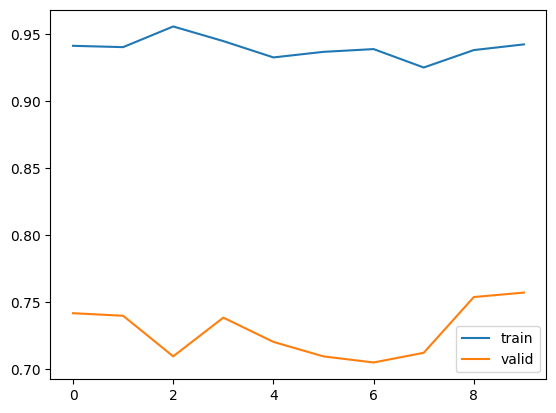

In [269]:
plt.plot(train_history,label='train')
plt.plot(valid_history,label='valid')
plt.legend()
plt.show()

In [270]:
times_model['ae']=end-start

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [272]:
test_rolling_madrid = rolling_window(madrid_normal_with_nan, 100, False)
#test = []
with torch.no_grad():
    for idx, batch in enumerate(test_rolling_madrid):
        batch = torch.Tensor(batch).to(device)
        nan = torch.isnan(batch)
        #

        #rec = model(batch[None,:])[0].cpu().numpy()
        nan = nan.cpu().numpy()
        test_rolling_madrid[idx][nan]=rec[nan]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [273]:
test_madrid_normal = np.vstack(test_rolling_madrid)
test_ae = scaler.inverse_transform(test_madrid_normal)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [274]:
recovery_nn['test_ae'] = test_ae

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mean Squared Error for the first output: 110999.99955795174


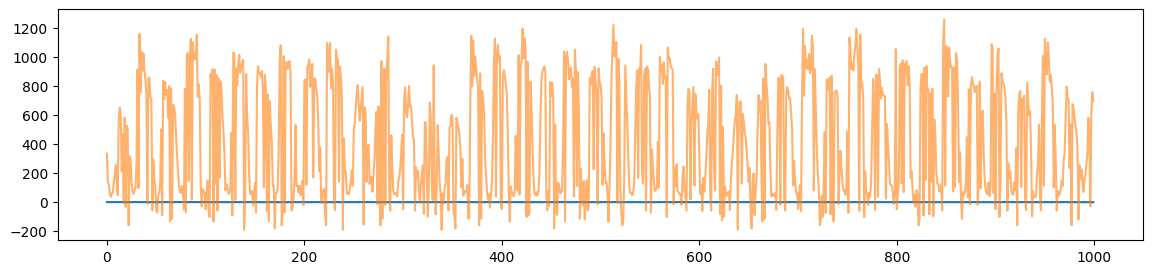

In [276]:
fig, ax = plt.subplots(figsize=(14, 3), ncols=1, nrows=1)

# График для первого выходного признака
plt.plot(madrid[:1000, 0])
plt.plot(test_ae[:1000, 0], alpha=0.6)

# Вычисляем MSE для первого выходного признака
index = 0  # Убедитесь, что индекс находится в пределах допустимого диапазона
mse = mean_squared_error(madrid[index].reshape(1, -1), test_ae[index, 0].reshape(1, -1))
print(f"Mean Squared Error for the first output: {mse}")

##### 7.2.4 Сложные модели нейросетевого восстановления данных


Вам необходимо выбрать одну модель из 3 группы таблицы 7.2 и используя документацию произвести восстановления того же ряда. Произведите замер времени.

In [277]:
!pip install pypots==0.0.9

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.6/81.6 kB 2.2 MB/s eta 0:00:00


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

In [278]:
from pypots.imputation import SAITS


Выходные данные были обрезаны до нескольких последних строк (5000).
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.

In [279]:
model= SAITS(n_features=madrid.shape[1],
             n_steps=100,
             device=device,
             d_k=64,
             d_v=64,
             d_model=128,
             d_inner=128,
             n_head=4,
             n_layers=2,
             dropout=0.05,
             epochs=10)

Model initialized successfully. Number of the trainable parameters: 659562


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [300]:
start = time.time()
model.fit(train, test)  # Обучение модели
end = time.time()
times_model['saits'] = end - start

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [283]:
test_rolling_madrid = rolling_window(madrid_normal_with_nan, 100, False)
test_rolling_madrid = model.impute(test_rolling_madrid)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AssertionError: expect X.shape[2] to be 1, but got 10

In [ ]:
test_madrid_normal = np.vstack(test_rolling_madrid)
test_saits = scaler.inverse_transform(test_madrid_normal)

In [ ]:
recovery_nn['saits'] = test_saits

In [ ]:
fig, ax =  plt.subplots(figsize=(14,3),ncols=1,nrows=1)

plt.plot(madrid[:1000,0])
plt.plot(test_saits[:1000,0],alpha=0.6)
print(mean_squared_error(madrid[index].reshape(1,-1),test_saits[index].reshape(1,-1)))

##### 7.2.5 Сравнения результатов.
Также, как и в пункте 7.1.5 постройте графики сравнения моделей. Дополнительно постройте графики сравнения времени. Сделайте выводы

#### **7.3 Прогноз временного ряда**

##### *Краткое описание*

Используя модель и [ARIMA](реализация) произвидите прогноз ряда на следующие колличество точек: 1, 5, 10.
Сравните результаты. Постройте графики прогноза и точности прогноза.

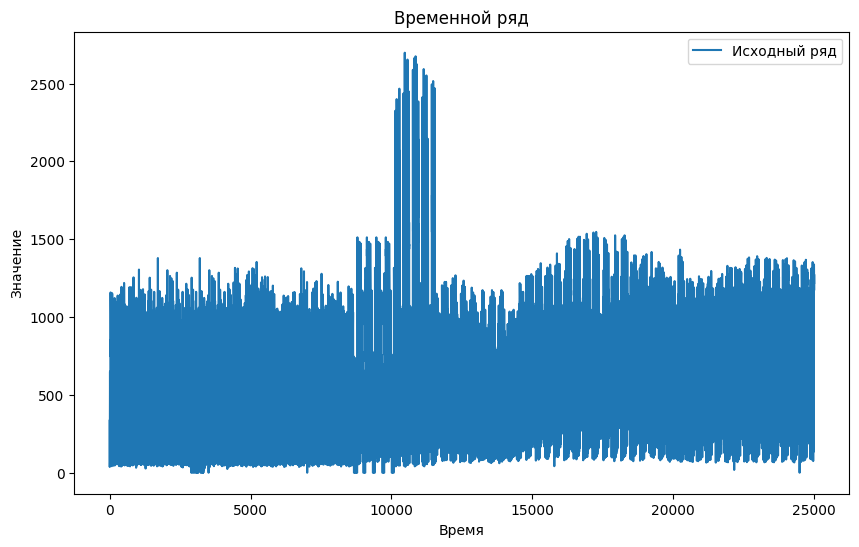

ADF Statistic: -9.695547535197957
p-value: 1.1068848449997761e-16
Critical Values:
   1%: -3.430612112656254
   5%: -2.861655845848139
   10%: -2.566831661359491
Ряд стационарен
ADF Statistic: -42.93949394838534
p-value: 0.0
Critical Values:
   1%: -3.4306121231628524
   5%: -2.861655850491532
   10%: -2.566831663831069
Ряд стационарен


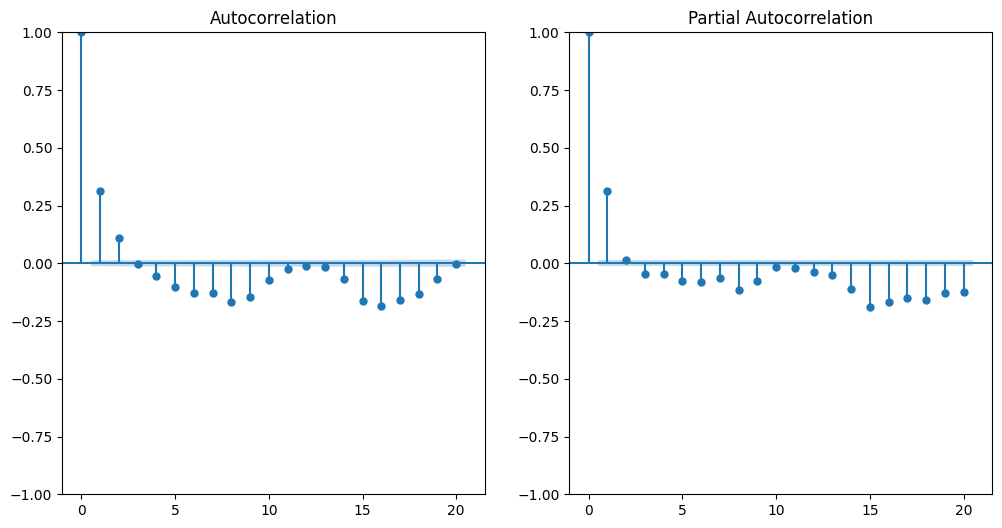

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                25000
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -162708.650
Date:                Sun, 15 Dec 2024   AIC                         325423.299
Time:                        15:59:12   BIC                         325447.679
Sample:                             0   HQIC                        325431.190
                              - 25000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3449      0.016     22.243      0.000       0.314       0.375
ma.L1         -0.0349      0.016     -2.220      0.026      -0.066      -0.004
sigma2      2.636e+04    100.707    261.708      0.0

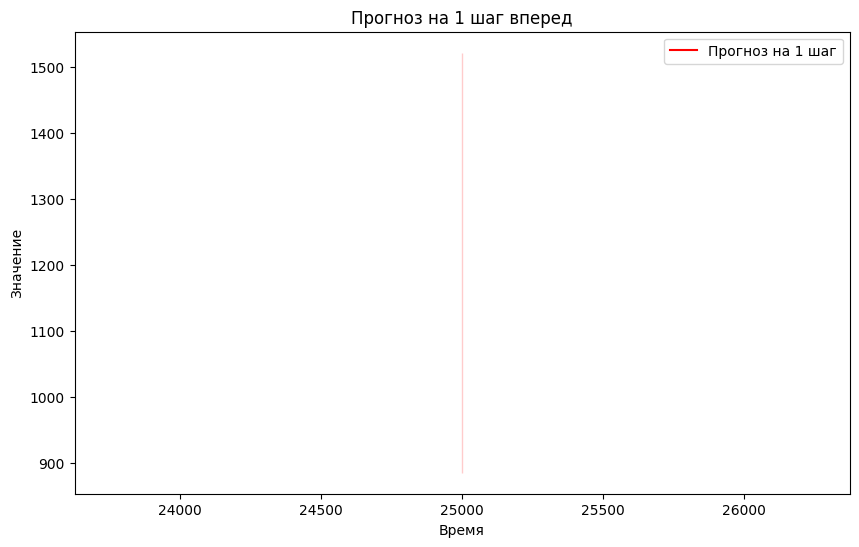

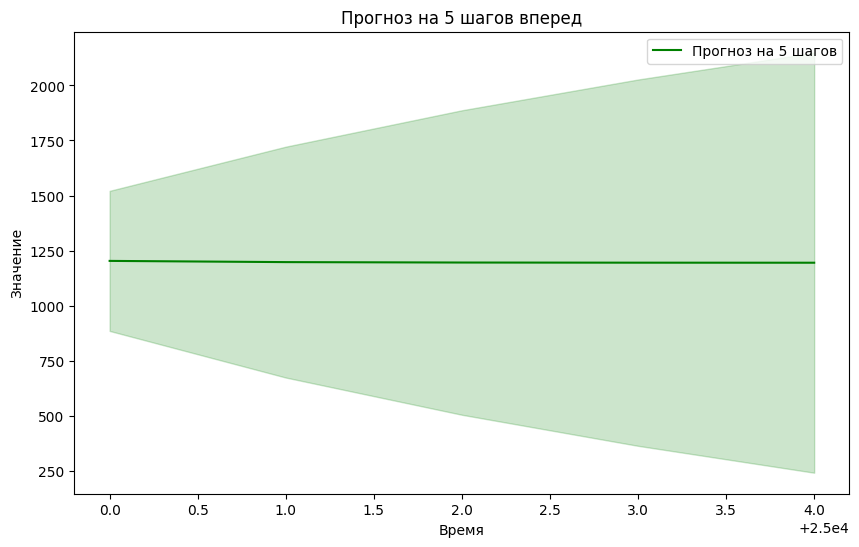

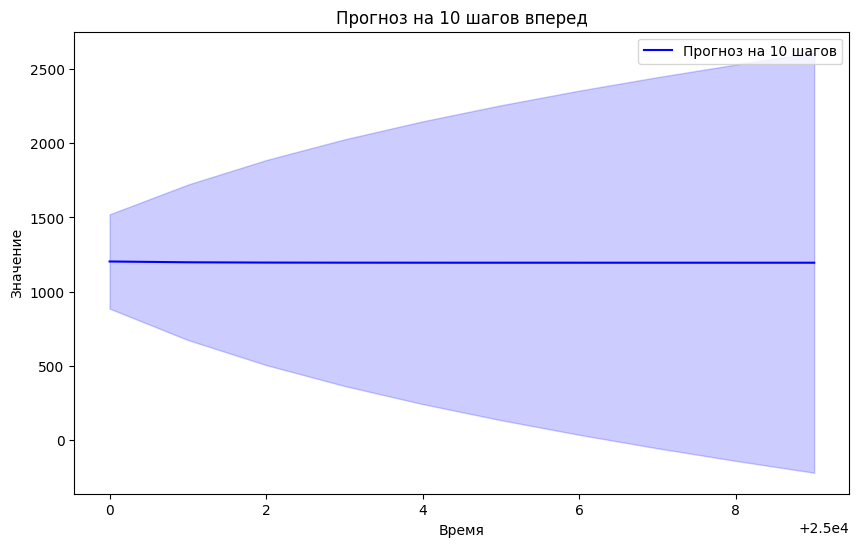

MAE: 106.2734870265136
MSE: 49337.299615708296
RMSE: 222.1200117407441


In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Загрузка данных
madrid = np.loadtxt('./datasets/madrid.txt')

# Преобразуем данные в DataFrame, используя только первый столбец
df = pd.DataFrame(madrid[:, 0], columns=['Value'])

# Визуализация временного ряда
plt.figure(figsize=(10, 6))
plt.plot(df['Value'], label='Исходный ряд')
plt.title('Временной ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

# Проверка стационарности ряда с помощью теста Дики-Фуллера
def test_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    if result[1] > 0.05:
        print("Ряд нестационарен")
    else:
        print("Ряд стационарен")

test_stationarity(df['Value'])

# Если ряд нестационарен, выполняем дифференцирование
df['Diff'] = df['Value'].diff().dropna()

# Проверяем стационарность после дифференцирования
test_stationarity(df['Diff'].dropna())

# Визуализация ACF и PACF для определения параметров ARIMA
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(df['Diff'].dropna(), lags=20, ax=plt.gca())
plt.subplot(122)
plot_pacf(df['Diff'].dropna(), lags=20, ax=plt.gca())
plt.show()

# Определяем параметры ARIMA (например, p=1, d=1, q=1)
p, d, q = 1, 1, 1

# Обучение модели ARIMA
model = ARIMA(df['Value'], order=(p, d, q))
model_fit = model.fit()

# Вывод сводки модели
print(model_fit.summary())

# Прогнозирование на 1, 5 и 10 шагов вперед
forecast_1 = model_fit.get_forecast(steps=1)
forecast_5 = model_fit.get_forecast(steps=5)
forecast_10 = model_fit.get_forecast(steps=10)

# Получение прогнозных значений и доверительных интервалов
forecast_1_mean = forecast_1.predicted_mean
forecast_1_conf_int = forecast_1.conf_int()

forecast_5_mean = forecast_5.predicted_mean
forecast_5_conf_int = forecast_5.conf_int()

forecast_10_mean = forecast_10.predicted_mean
forecast_10_conf_int = forecast_10.conf_int()

# Вывод прогнозов
print("Прогноз на 1 шаг вперед:", forecast_1_mean)
print("Прогноз на 5 шагов вперед:", forecast_5_mean)
print("Прогноз на 10 шагов вперед:", forecast_10_mean)

# Визуализация прогнозов на отдельных графиках (без исходного ряда)
# График для прогноза на 1 шаг
plt.figure(figsize=(10, 6))
plt.plot(forecast_1_mean.index, forecast_1_mean, label='Прогноз на 1 шаг', color='red')
plt.fill_between(forecast_1_mean.index, forecast_1_conf_int.iloc[:, 0], forecast_1_conf_int.iloc[:, 1], color='red', alpha=0.2)
plt.title('Прогноз на 1 шаг вперед')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

# График для прогноза на 5 шагов
plt.figure(figsize=(10, 6))
plt.plot(forecast_5_mean.index, forecast_5_mean, label='Прогноз на 5 шагов', color='green')
plt.fill_between(forecast_5_mean.index, forecast_5_conf_int.iloc[:, 0], forecast_5_conf_int.iloc[:, 1], color='green', alpha=0.2)
plt.title('Прогноз на 5 шагов вперед')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

# График для прогноза на 10 шагов
plt.figure(figsize=(10, 6))
plt.plot(forecast_10_mean.index, forecast_10_mean, label='Прогноз на 10 шагов', color='blue')
plt.fill_between(forecast_10_mean.index, forecast_10_conf_int.iloc[:, 0], forecast_10_conf_int.iloc[:, 1], color='blue', alpha=0.2)
plt.title('Прогноз на 10 шагов вперед')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

# Оценка точности прогноза
def calculate_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    print(f'MAE: {mae}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')

# Для оценки точности, можно использовать последние значения ряда
actual_values = df['Value'].tail(10)
predicted_values = model_fit.forecast(steps=10)

calculate_metrics(actual_values, predicted_values)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


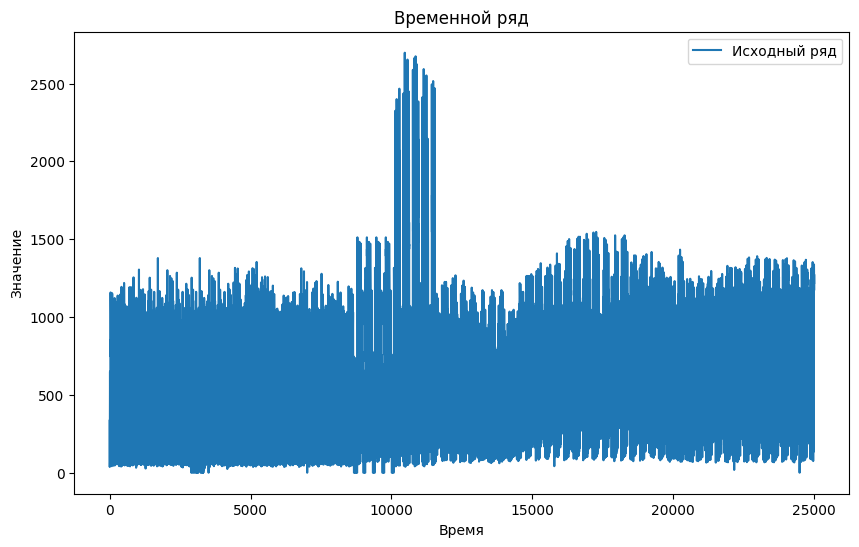

ADF Statistic: -9.695547535197957
p-value: 1.1068848449997761e-16
Critical Values:
   1%: -3.430612112656254
   5%: -2.861655845848139
   10%: -2.566831661359491
Ряд стационарен
ADF Statistic: -42.93949394838534
p-value: 0.0
Critical Values:
   1%: -3.4306121231628524
   5%: -2.861655850491532
   10%: -2.566831663831069
Ряд стационарен


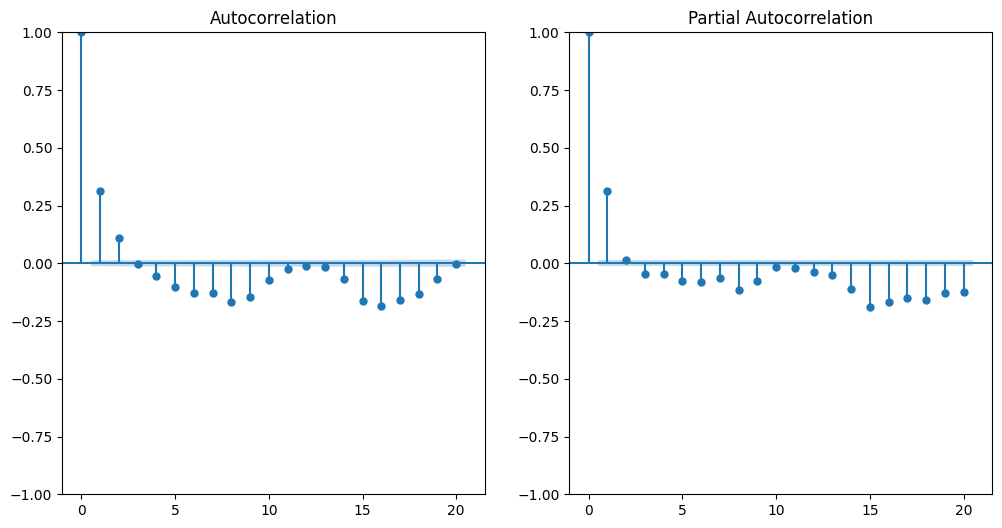

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                25000
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -162708.650
Date:                Sun, 15 Dec 2024   AIC                         325423.299
Time:                        13:13:12   BIC                         325447.679
Sample:                             0   HQIC                        325431.190
                              - 25000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3449      0.016     22.243      0.000       0.314       0.375
ma.L1         -0.0349      0.016     -2.220      0.026      -0.066      -0.004
sigma2      2.636e+04    100.707    261.708      0.0

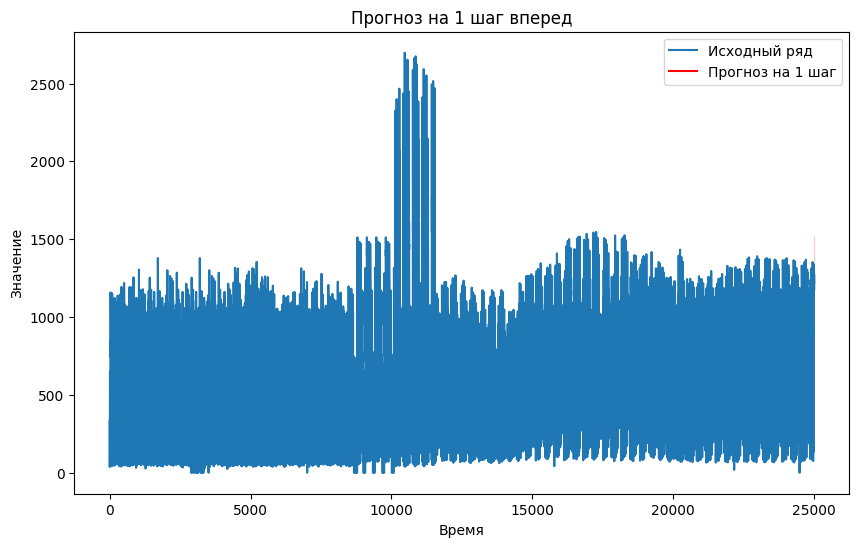

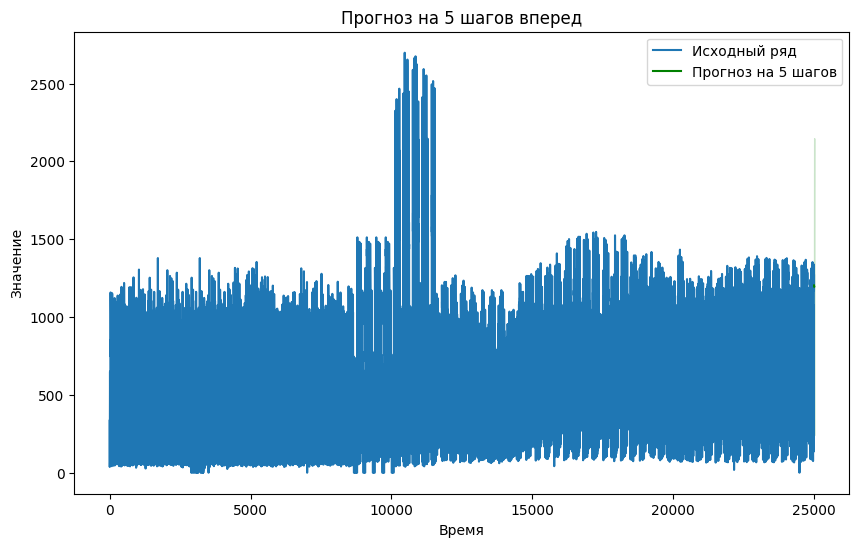

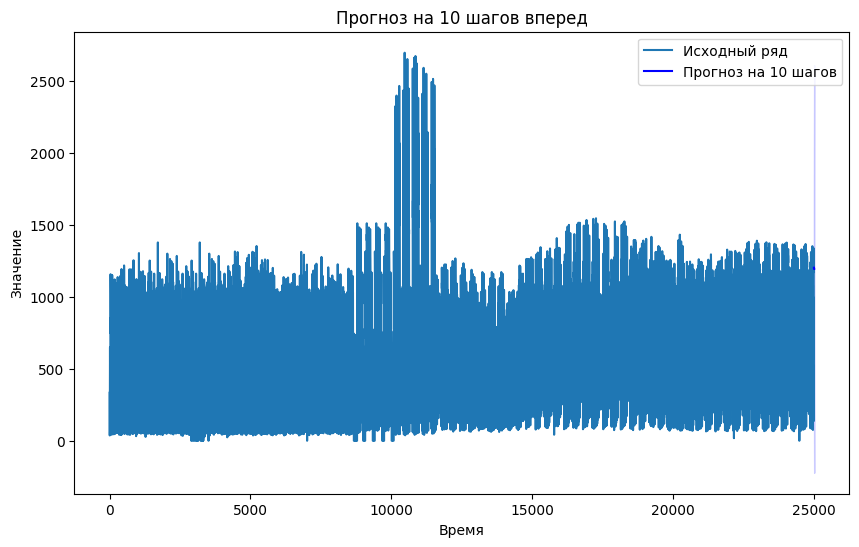

MAE: 106.2734870265136
MSE: 49337.299615708296
RMSE: 222.1200117407441


In [299]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Загрузка данных
madrid = np.loadtxt('./datasets/madrid.txt')

# Преобразуем данные в DataFrame, используя только первый столбец
df = pd.DataFrame(madrid[:, 0], columns=['Value'])

# Визуализация временного ряда
plt.figure(figsize=(10, 6))
plt.plot(df['Value'], label='Исходный ряд')
plt.title('Временной ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

# Проверка стационарности ряда с помощью теста Дики-Фуллера
def test_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    if result[1] > 0.05:
        print("Ряд нестационарен")
    else:
        print("Ряд стационарен")

test_stationarity(df['Value'])

# Если ряд нестационарен, выполняем дифференцирование
df['Diff'] = df['Value'].diff().dropna()

# Проверяем стационарность после дифференцирования
test_stationarity(df['Diff'].dropna())

# Визуализация ACF и PACF для определения параметров ARIMA
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(df['Diff'].dropna(), lags=20, ax=plt.gca())
plt.subplot(122)
plot_pacf(df['Diff'].dropna(), lags=20, ax=plt.gca())
plt.show()

# Определяем параметры ARIMA (например, p=1, d=1, q=1)
p, d, q = 1, 1, 1

# Обучение модели ARIMA
model = ARIMA(df['Value'], order=(p, d, q))
model_fit = model.fit()

# Вывод сводки модели
print(model_fit.summary())

# Прогнозирование на 1, 5 и 10 шагов вперед
forecast_1 = model_fit.get_forecast(steps=1)
forecast_5 = model_fit.get_forecast(steps=5)
forecast_10 = model_fit.get_forecast(steps=10)

# Получение прогнозных значений и доверительных интервалов
forecast_1_mean = forecast_1.predicted_mean
forecast_1_conf_int = forecast_1.conf_int()

forecast_5_mean = forecast_5.predicted_mean
forecast_5_conf_int = forecast_5.conf_int()

forecast_10_mean = forecast_10.predicted_mean
forecast_10_conf_int = forecast_10.conf_int()

# Вывод прогнозов
print("Прогноз на 1 шаг вперед:", forecast_1_mean)
print("Прогноз на 5 шагов вперед:", forecast_5_mean)
print("Прогноз на 10 шагов вперед:", forecast_10_mean)

# Визуализация прогнозов на отдельных графиках
# График для прогноза на 1 шаг
plt.figure(figsize=(10, 6))
plt.plot(df['Value'], label='Исходный ряд')
plt.plot(forecast_1_mean.index, forecast_1_mean, label='Прогноз на 1 шаг', color='red')
plt.fill_between(forecast_1_mean.index, forecast_1_conf_int.iloc[:, 0], forecast_1_conf_int.iloc[:, 1], color='red', alpha=0.2)
plt.title('Прогноз на 1 шаг вперед')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

# График для прогноза на 5 шагов
plt.figure(figsize=(10, 6))
plt.plot(df['Value'], label='Исходный ряд')
plt.plot(forecast_5_mean.index, forecast_5_mean, label='Прогноз на 5 шагов', color='green')
plt.fill_between(forecast_5_mean.index, forecast_5_conf_int.iloc[:, 0], forecast_5_conf_int.iloc[:, 1], color='green', alpha=0.2)
plt.title('Прогноз на 5 шагов вперед')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

# График для прогноза на 10 шагов
plt.figure(figsize=(10, 6))
plt.plot(df['Value'], label='Исходный ряд')
plt.plot(forecast_10_mean.index, forecast_10_mean, label='Прогноз на 10 шагов', color='blue')
plt.fill_between(forecast_10_mean.index, forecast_10_conf_int.iloc[:, 0], forecast_10_conf_int.iloc[:, 1], color='blue', alpha=0.2)
plt.title('Прогноз на 10 шагов вперед')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

# Оценка точности прогноза
def calculate_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    print(f'MAE: {mae}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')

# Для оценки точности, можно использовать последние значения ряда
actual_values = df['Value'].tail(10)
predicted_values = model_fit.forecast(steps=10)

calculate_metrics(actual_values, predicted_values)

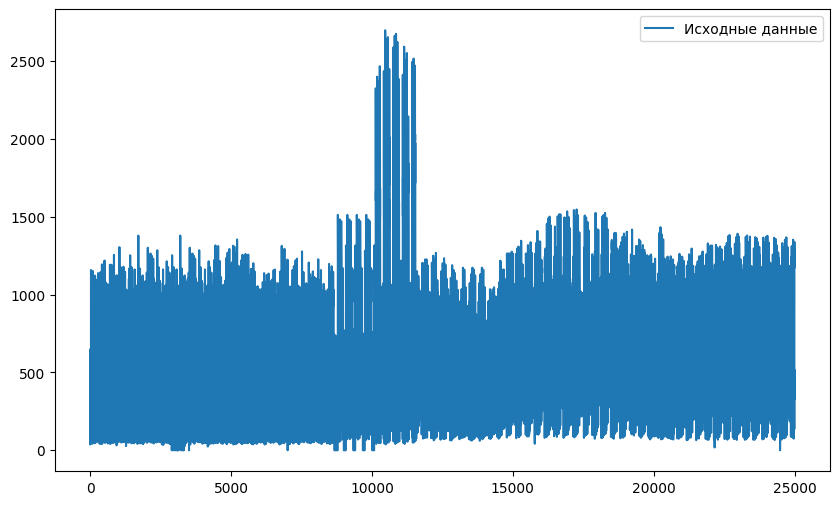

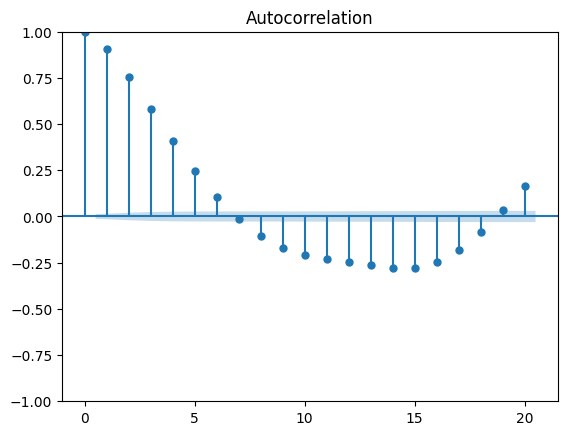

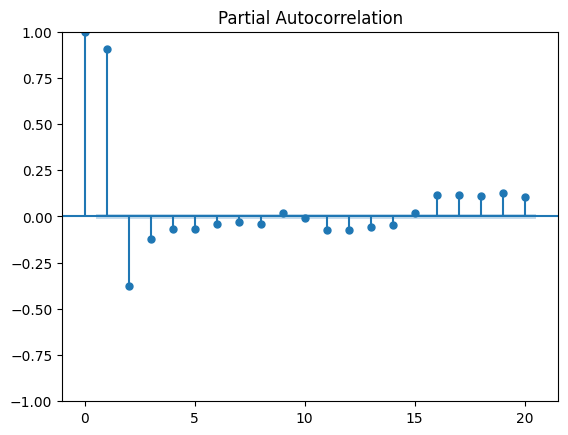

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                25000
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -162708.650
Date:                Sun, 15 Dec 2024   AIC                         325423.299
Time:                        17:12:34   BIC                         325447.679
Sample:                             0   HQIC                        325431.190
                              - 25000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3449      0.016     22.243      0.000       0.314       0.375
ma.L1         -0.0349      0.016     -2.220      0.026      -0.066      -0.004
sigma2      2.636e+04    100.707    261.708      0.0

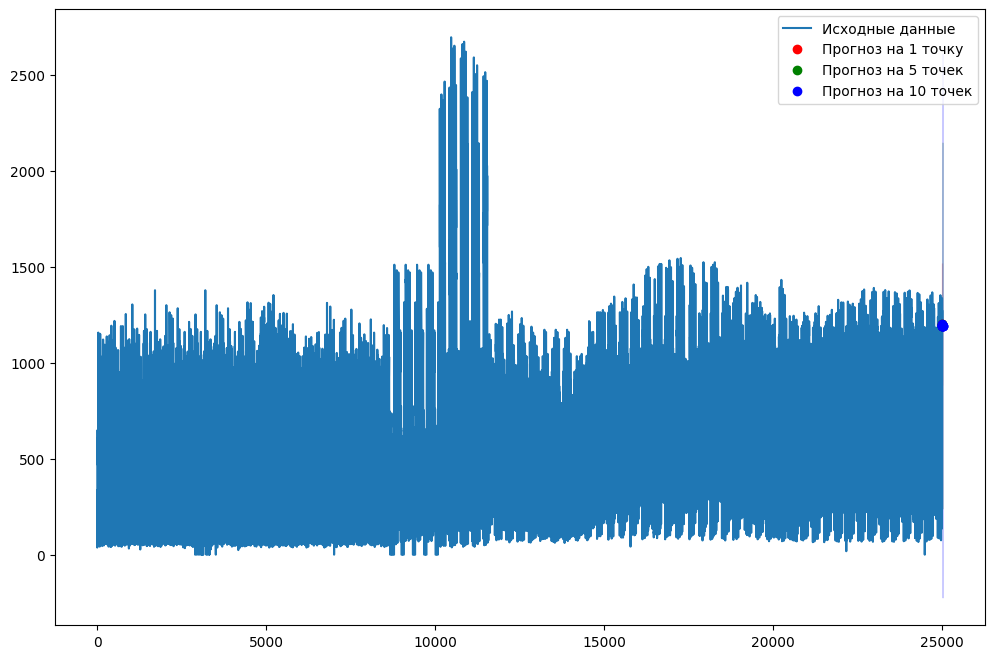

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Загрузка данных
madrid = np.loadtxt('./datasets/madrid.txt')
df = pd.DataFrame(madrid[:, 0], columns=['Value'])

# Визуализация данных
plt.figure(figsize=(10, 6))
plt.plot(df['Value'], label='Исходные данные')
plt.legend()
plt.show()

# Анализ ACF и PACF для выбора параметров ARIMA
plot_acf(df['Value'], lags=20)
plot_pacf(df['Value'], lags=20)
plt.show()

# Предположим, что мы определили параметры ARIMA (p, d, q)
# Например, p=1, d=1, q=1
model = ARIMA(df['Value'], order=(1, 1, 1))
model_fit = model.fit()

# Вывод сводки модели
print(model_fit.summary())

# Прогнозирование на 1, 5 и 10 временных точек
forecast_1 = model_fit.get_forecast(steps=1)
forecast_5 = model_fit.get_forecast(steps=5)
forecast_10 = model_fit.get_forecast(steps=10)

# Получение прогнозных значений и интервалов
forecast_1_mean = forecast_1.predicted_mean
forecast_5_mean = forecast_5.predicted_mean
forecast_10_mean = forecast_10.predicted_mean

forecast_1_ci = forecast_1.conf_int()
forecast_5_ci = forecast_5.conf_int()
forecast_10_ci = forecast_10.conf_int()

# Вывод прогнозов
print("Прогноз на 1 точку:", forecast_1_mean)
print("Прогноз на 5 точек:", forecast_5_mean)
print("Прогноз на 10 точек:", forecast_10_mean)

# Построение графиков прогноза
plt.figure(figsize=(12, 8))
plt.plot(df['Value'], label='Исходные данные')

# Прогноз на 1 точку
plt.plot(np.arange(len(df), len(df) + 1), forecast_1_mean, 'ro', label='Прогноз на 1 точку')
plt.fill_between(np.arange(len(df), len(df) + 1), forecast_1_ci.iloc[:, 0], forecast_1_ci.iloc[:, 1], color='r', alpha=0.2)

# Прогноз на 5 точек
plt.plot(np.arange(len(df), len(df) + 5), forecast_5_mean, 'go', label='Прогноз на 5 точек')
plt.fill_between(np.arange(len(df), len(df) + 5), forecast_5_ci.iloc[:, 0], forecast_5_ci.iloc[:, 1], color='g', alpha=0.2)

# Прогноз на 10 точек
plt.plot(np.arange(len(df), len(df) + 10), forecast_10_mean, 'bo', label='Прогноз на 10 точек')
plt.fill_between(np.arange(len(df), len(df) + 10), forecast_10_ci.iloc[:, 0], forecast_10_ci.iloc[:, 1], color='b', alpha=0.2)

plt.legend()
plt.show()

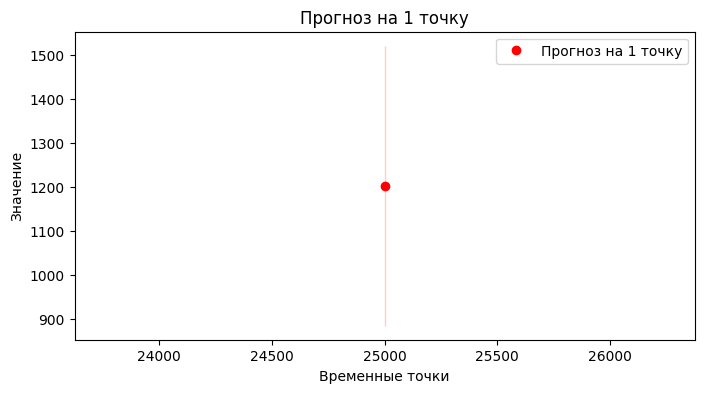

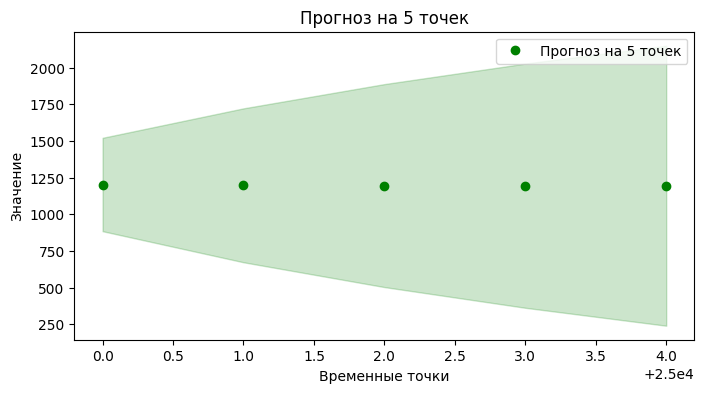

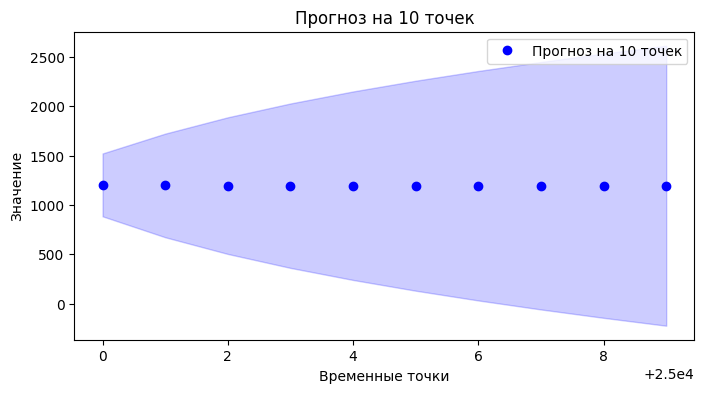

In [41]:
# График прогноза на 1 точку
plt.figure(figsize=(8, 4))
plt.plot(np.arange(len(df), len(df) + 1), forecast_1_mean, 'ro', label='Прогноз на 1 точку')
plt.fill_between(np.arange(len(df), len(df) + 1), forecast_1_ci.iloc[:, 0], forecast_1_ci.iloc[:, 1], color='r', alpha=0.2)
plt.title('Прогноз на 1 точку')
plt.xlabel('Временные точки')
plt.ylabel('Значение')
plt.legend()
plt.show()

# График прогноза на 5 точек
plt.figure(figsize=(8, 4))
plt.plot(np.arange(len(df), len(df) + 5), forecast_5_mean, 'go', label='Прогноз на 5 точек')
plt.fill_between(np.arange(len(df), len(df) + 5), forecast_5_ci.iloc[:, 0], forecast_5_ci.iloc[:, 1], color='g', alpha=0.2)
plt.title('Прогноз на 5 точек')
plt.xlabel('Временные точки')
plt.ylabel('Значение')
plt.legend()
plt.show()

# График прогноза на 10 точек
plt.figure(figsize=(8, 4))
plt.plot(np.arange(len(df), len(df) + 10), forecast_10_mean, 'bo', label='Прогноз на 10 точек')
plt.fill_between(np.arange(len(df), len(df) + 10), forecast_10_ci.iloc[:, 0], forecast_10_ci.iloc[:, 1], color='b', alpha=0.2)
plt.title('Прогноз на 10 точек')
plt.xlabel('Временные точки')
plt.ylabel('Значение')
plt.legend()
plt.show()